<!-- ## ЕМ алгоритм для максимизации обоснованности

* Модель: $y = Xw + \varepsilon$ , $w \sim \mathcal{N} (w | 0 , A^{-1}) ,  \varepsilon \sim \mathcal{N} (0 , \beta^{-1} I)$ -->

## ЕМ алгоритм для восстановления плотности

* Модель : $p(x,\theta,w) = \sum\limits_{i= 1}^K w_i \varphi_i(x, \theta_i)$ , $\sum w_i = 1 , w_i\ge 0$

* MLE: $\max \log P(w ,\theta ) = \sum\limits_{m= 1}^l \log \sum\limits_{i= 1}^K w_i \varphi_i(x_m, \theta_i)$

* $L = \sum\limits_{m = 1}^l \log \sum\limits_{i= 1}^K w_i \varphi_i(x_m,\theta _i) - \lambda(\sum w_i - 1)$

* $\frac{\partial L}{\partial w_j} = \sum\limits_{m=1}^l\frac{\varphi_j(x_m,\theta_j)}{\sum\limits_{i= 1}^K w_i \varphi_i(x_m,\theta_i)} - \lambda  = 0$

* $\sum\limits_{i= 1}^K w_i \varphi_i(x_m,\theta_i) = p(x_m)$

* $g_{ij} = \frac{w_j \varphi_j(x_i, \theta_j)}{p(x_i)}$

* $\sum\limits_{i=1}^lg_{ij} = \lambda w_j$

* $\sum\limits_{j=1}^K \sum\limits_{i=1}^lg_{ij} = l = \sum\limits_{j=1}^K \lambda w_j = \lambda $

* $w_j = \frac{1}{l}\sum\limits_{i=1}^lg_{ij}$

* $\frac{\partial L}{\partial \theta_j} = \sum\limits_{i=1}^l \frac{w_j \varphi_j'(x_i, \theta_j)}{\sum\limits_{k = 1}^K w_k \varphi_k(x_i,\theta_k)} = \sum\limits_{i=1}^l \frac{w_j \varphi_j'(x_i, \theta_j) \cdot \varphi_j(x_i, \theta_j)}{\sum\limits_{k = 1}^K w_k \varphi_k(x_i,\theta_k) \cdot \varphi_j(x_i, \theta_j)} = \frac{\partial}{\partial \theta_j}\sum\limits_{i=1}^l g_{ij} \log \varphi_j(x_i, \theta_j)$


## Получаем ЕМ алгоритм:

## Е шаг:

* подсчет $g_{ij}$ для всех $i , j$

## M шаг:

* Для всех $j$ :

* $\theta_j = arg\max \sum\limits_{i=1}^l g_{ij} \log \varphi_j(x_i, \theta_j)$

* $w_j = \frac{1}{l} \sum g_{ij}$

# Гауссианы

* $\varphi_i(x,\theta_i) = \mathcal{N}(m_i ,\Sigma_i )$

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def gaussian(w , m , sigma , size = 100):
    X = np.array([])
    components = np.array([])
    A = np.linalg.cholesky(sigma)
    for k in range(len(w)) :
        N_k = int(w[k] * size)
        X_k = m[k] + np.random.normal(size = (N_k,m.shape[1]))@A[k].T
        print(X_k.shape)
        if len(X) == 0 :
            X = X_k
        else :
            X = np.concatenate([X,X_k])
        components = np.concatenate([components ,np.ones(N_k)*k ])

    return X , components

def plot_points(X, colors , m = None ):
    plt.figure(figsize=(8, 6))

    if m is not None :
        plt.scatter(m[:,0], m[:, 1], marker ='x')
    plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='viridis')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label='Номер цвета')
    plt.grid(True)
    plt.title('Отображение точек с подкраской')
    plt.show()

In [3]:
m = np.array([[1,1], [6,6]])
sigma = np.array([[[0.1,0],[0,0.9]] , [[0.9,0.1],[0.2,0.1]]])
w = np.array([0.3 ,0.7])

In [4]:
X, components = gaussian(w , m, sigma, size = 10000)

(3000, 2)
(7000, 2)


In [5]:
X.shape , components.shape

((10000, 2), (10000,))

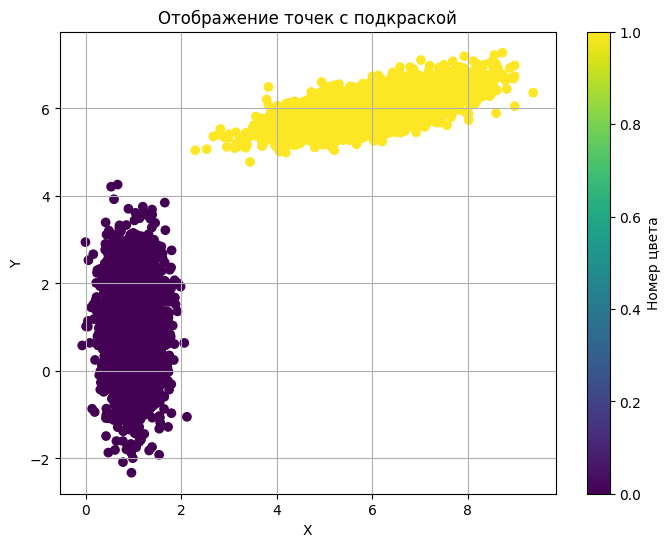

In [6]:
plot_points(X ,components , m = m )

## EM algorthm

In [10]:
from scipy.stats import multivariate_normal

In [15]:
def initialize_parameters(data, num_components):
    num_samples, num_features = data.shape
    np.random.seed(0)
    means = [np.random.rand(num_features) for _ in range(num_components)]
    covariances = [np.eye(num_features) for _ in range(num_components)]
    weights = np.ones(num_components) / num_components
    return {'means': means, 'covariances': covariances, 'weights': weights}

def expectation_step(data, parameters):
    num_samples = data.shape[0]
    num_components = len(parameters['means'])
    responsibilities = np.zeros((num_samples, num_components))
    for i in range(num_components):
        mvn = multivariate_normal(mean=parameters['means'][i], cov=parameters['covariances'][i])
        responsibilities[:, i] = parameters['weights'][i] * mvn.pdf(data)
    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
    return responsibilities

def maximization_step(data, responsibilities):
    num_samples, num_features = data.shape
    num_components = responsibilities.shape[1]
    total_responsibilities = np.sum(responsibilities, axis=0)
    weights = total_responsibilities / num_samples
    means = np.dot(responsibilities.T, data) / total_responsibilities[:, np.newaxis]
    covariances = []
    for i in range(num_components):
        diff = data - means[i]
        cov = np.dot(responsibilities[:, i] * diff.T, diff) / total_responsibilities[i]
        covariances.append(cov)
    return {'means': means, 'covariances': covariances, 'weights': weights}

def em_algorithm(data, num_components, num_iterations):
    parameters = initialize_parameters(data, num_components)
    for _ in range(num_iterations):
        responsibilities = expectation_step(data, parameters)
        parameters = maximization_step(data, responsibilities)
    return parameters

In [17]:

num_components = 2
num_iterations = 100
estimated_params = em_algorithm(X, num_components, num_iterations)

print("Оцененные средние:")
print(estimated_params['means'])
print("Оцененные ковариации:")
print(estimated_params['covariances'])
print("Оцененные веса:")
print(estimated_params['weights'])

Оцененные средние:
[[6.00718498 5.99995443]
 [0.99930213 0.99055557]]
Оцененные ковариации:
[array([[0.89231072, 0.19932566],
       [0.19932566, 0.09910459]]), array([[ 0.09921691, -0.00525724],
       [-0.00525724,  0.87455303]])]
Оцененные веса:
[0.7 0.3]
